In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

In [ ]:
# import all thr librarys

In [3]:
import os 
import torch
import torch.nn as nn
import torchvision.transforms as tf 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.utils import save_image
from PIL import Image
%matplotlib inline

In [4]:
#Making sure that the GPU is working

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
#Loading the data and resizing the data

In [7]:
dirc= r'C:\Users\altul\Downloads\Level-4\DS-660\project\archive\img_celeba\cel'

In [8]:
workers=2
batch_size=128
image_size=64
ms=((0.5,0.5,0.5),(0.5,0.5,0.5))

In [9]:
dataset = ImageFolder(dirc,
                           transform=tf.Compose([
                               tf.Resize(image_size),
                               tf.CenterCrop(image_size),
                               tf.ToTensor(),
                               tf.Normalize(*ms),
                           ]))
# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [10]:
#The length of the data

In [11]:
len(dataset)

202032

In [12]:
# image sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])

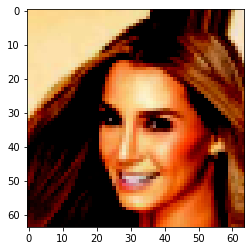

In [13]:
image,_ = dataset[0]
plt.imshow(image.permute(1,2,0))
image.size()

In [ ]:
#denormalized

In [14]:
def denormalized(img):
    return img * ms[1][0] + ms[0][0]

In [15]:
#help(torch.ones)

torch.Size([128, 3, 64, 64])


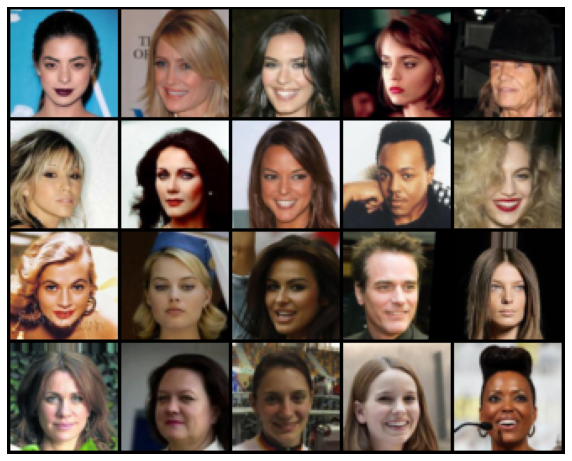

In [16]:
image,_ = next(iter(dataloader))
print(image.shape)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(make_grid(denormalized(image)[:20],nrow=5).permute(1,2,0))

In [17]:
#Adding the data to the GPU

In [18]:
def deviceLoaderfunc(data,device):
    if isinstance(data,(list,tuple)):
        return [deviceLoaderfunc(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [19]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield deviceLoaderfunc(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [20]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
dataloader = DeviceDataLoader(dataloader, device)

In [22]:
latent_size = 128

In [23]:
#the code for the discriminator

In [24]:
discriminator = nn.Sequential(
    # 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()) # we generally use sigmoid function at the end of all network to finally 
                # get the bounded result

In [25]:
# loading the discriminator to the GPU

In [26]:
discriminator = deviceLoaderfunc(discriminator, device)

In [27]:
# the generator code

In [28]:
generator = nn.Sequential(
    # 128 x 1 x 1  here 128 is the latent size

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    # 512 x 4 x 4 upsampled data

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    # 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    # 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    # 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # 3 x 64 x 64
)

In [29]:
#loading the generator to the GPU

In [30]:
generator = deviceLoaderfunc(generator, device)

In [31]:
def train_discriminator(r_images,optimizer):
    
    optimizer.zero_grad()
    # prediction
    # setting the target for prediction
    # calculating loss
    # getting score
    r_preds=discriminator(r_images)
    r_targets=torch.ones(r_images.size(0),1,device=device)# our target is to get result one for real images
    r_loss = F.binary_cross_entropy(r_preds, r_targets) # used for yes or no , fake or not fake type data
    r_score = torch.mean(r_preds).item()

    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    g_images = generator(latent) # generating fake images
    
    # Pass fake images through discriminator
    g_targets = torch.zeros(g_images.size(0), 1, device=device)
    g_preds = discriminator(g_images)
    g_loss = F.binary_cross_entropy(g_preds, g_targets)
    g_score = torch.mean(g_preds).item()

    # Updating discriminator weights
    loss = r_loss + g_loss
    loss.backward()
    optimizer.step()
    return loss.item(), r_score,g_score

In [32]:
# TRAIN THE generator

In [33]:
def train_generator(optimizer):
    
    optimizer.zero_grad()
    # generating fake images(generating)
    # prediction(discriminator)
    # setting targets
    # calculating loss
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    g_images = generator(latent)
    
    preds = discriminator(g_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [34]:

latent_noise = torch.randn(64, latent_size, 1, 1, device=device)
os.makedirs('new_gen_img', exist_ok=True)
def fit(epochs, lr, index=1):
    
    torch.cuda.empty_cache()
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    # beta values changes learning speed. Changes exponentially , so beta values should not be
    # too low as it will furiously decrease the learning speed with increasing number of batches 
    # and epochs
    
    for epoch in range(epochs):
        for r_images, _ in tqdm(dataloader):
            loss_d, r_score, g_score = train_discriminator(r_images, d_optimizer)
            loss_g = train_generator(g_optimizer)
        
        # saving images with save_image module of torchvision
        g_images=generator(latent_noise)
        fimg_name='images-{0:0=4d}.png'.format(epoch+index,)
        save_image(denormalized(g_images),os.path.join('new_gen_img',fimg_name),nrow=4)
        
        print(" {} out of {} epochs, loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, r_score, g_score))

In [ ]:
# trin the module

In [35]:
records=fit(10,0.0002)

  0%|          | 0/1579 [00:00<?, ?it/s]

 1 out of 10 epochs, loss_g: 4.0290, loss_d: 0.3287, real_score: 0.8539, fake_score: 0.1374


  0%|          | 0/1579 [00:00<?, ?it/s]

 2 out of 10 epochs, loss_g: 4.6886, loss_d: 0.1688, real_score: 0.9551, fake_score: 0.1103


  0%|          | 0/1579 [00:00<?, ?it/s]

 3 out of 10 epochs, loss_g: 5.3595, loss_d: 0.3483, real_score: 0.9610, fake_score: 0.2417


  0%|          | 0/1579 [00:00<?, ?it/s]

 4 out of 10 epochs, loss_g: 2.6655, loss_d: 0.2402, real_score: 0.8733, fake_score: 0.0716


  0%|          | 0/1579 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#sampling the result

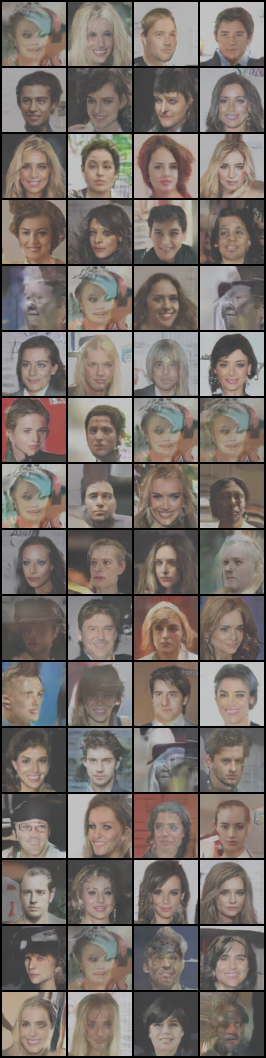

In [105]:
Image.open('./new_gen_img/images-0250.png')

In [ ]:
#Adding the imaging together to create a video

In [106]:
import imageio
import shutil
rimg = r'C:\\Users\\altul\\Downloads\\Level-4\\DS-660\\project\\archive\\img_celeba\\new_gen_img\\200epoch'
images_to_gif = []
for filename in os.listdir(rimg):
    images_to_gif.append(imageio.imread(rimg + '\\' + filename))
imageio.mimsave('visual.gif', images_to_gif)
shutil.rmtree(rimg)

In [82]:
pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [83]:
pip install shutil

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil
